### Домашнее задание "Проблема качества данных"

Необходимо запустить практическую часть занятия, и посмотреть самому то, о чём говорили на лекции. По образу практики, попробуйте создать искусственный датасет с лишними столбцами. Целевую метку, при правильной обработке данных, формируйте таким образом, чтобы без затруднений её смогла описать линейная модель. Ориентируйтесь на то, что было показано во время занятия, и каждый шаг описывайте в markdown. 

#### Описание моделируемого датасета, его основных характеристик

Я решила сформировать датасет, отвечающий моим личным интересам. И как человек, увлекающийся музыкой и некоторое время игравший в группе, выбрала в качестве предметной области рынок музыкальных инструментов. Конкретнее: я сформирую датасет, имитирующий характеристики синтезаторов и по ним с помощью линейной модели буду предсказывать цену инструмента. 

![korg](korg.jpg)

Основные фичи, которые я планирую включить в датасет:
* Количество клавиш
* Габариты: длина, ширина, высота в мм
* Вес в кг
* Год выпуска
* Модель
* Цена - наш таргет

Немного подробнее о них:
1. **Количество клавиш** - одна из базовых характеристик. Обычно принимает значение из следующего списка [25, 37, 48, 61, 73, 76, 88] (по количеству полных октав от 2 до 7), исключения встречаются редко. Эту переменную можно рассматривать и как категориальную порядковую и как числовую. Оставляю её как числовую без преобразований, т.к. цена напрямую коррелирует с количеством - при прочих равных, чем больше клавиш, тем инструмент дороже.

2. **Длина, ширина, высота, вес** - простые числовые переменные. Параметры ширина и высота не очень существенно различаются для моделей разных размеров, но вот длина явно зависит от количество клавиш, а вес - от общих габаритов, поэтому у них тоже предполагается прямая корреляционная связь с ценой.

3. **Год выпуска** не даст много информации о цене. С одной стороны, неновые модели, снятые с производства, могут продаваться дешевле, т.к. проигрывают в конкуренции более современным. С другой стороны, наоборот, отдельные старые инструменты могут продаваться по завышенным расценкам именно из-за того, что это винтаж, олдскул и раритет.

4. **Модель** - для своего искуственного датасета я выберу три реально существующих марки музыкальных инструментов: Casio, Korg и Nord. Это категориальный параметр, но для предсказания цены он существенный, т.к. это характерные представители разных ценовых сегментов. В среднем инструменты Casio дешевые и больше для домашнего использования, Korg - крепкий середнячок, подходящий для концертной и студийной работы, а Nord - почти элита, дорогие и очень крутые инструменты. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

Датасет я предварительно выгрузила в csv, так как мне потребовалось произвести некоторые манипуляции со столбцами, чтобы получить ту зависимость цены от признаков, какую я хочу. Поэтому сейчас я подгружу этот csv-файл и буду работать с ним, как с незнакомым, чтобы показать логику преобразования столбцов. А код, который использовался при формировании датасета останется в конце ноутбука, там будут пояснения, как я задаю тот или иной параметр.

In [312]:
df = pd.read_csv('keabord_prices.csv')
df.head()

,Unnamed: 0,keys_quantity,model,length,width,height,year,weight,price
0,0,37,Nord,719,353,44,1981,8.867001,45211.0
1,1,73,Korg,1195,183,126,1981,17.800084,65149.0
2,2,76,Casio,1173,188,143,2004,10.154248,62543.0
3,3,37,Korg,673,391,71,2002,17.954510,30791.5
4,4,76,Nord,1108,234,129,1993,27.927483,79182.5


In [313]:
df.drop(['Unnamed: 0'], axis=1, inplace=True) #вылез столбец, дублирующий индексы, удалим его

In [300]:
# посмотрим основные стат. характеристики
df.describe()

,keys_quantity,length,width,height,year,weight,price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,58.706000,970.578000,258.742000,91.795000,1999.827000,14.894169,54581.656000
std,20.802411,300.729194,82.318028,32.939399,12.033365,10.630418,20417.389504
min,25.000000,385.000000,120.000000,35.000000,1980.000000,1.157515,12316.500000
25%,37.000000,720.750000,187.000000,64.000000,1989.000000,7.154733,37168.625000
50%,61.000000,1029.000000,257.000000,92.000000,2000.000000,12.042372,57011.500000
75%,76.000000,1216.000000,334.000000,120.000000,2010.000000,19.434522,69698.375000
max,88.000000,1515.000000,400.000000,150.000000,2020.000000,66.754195,93984.000000


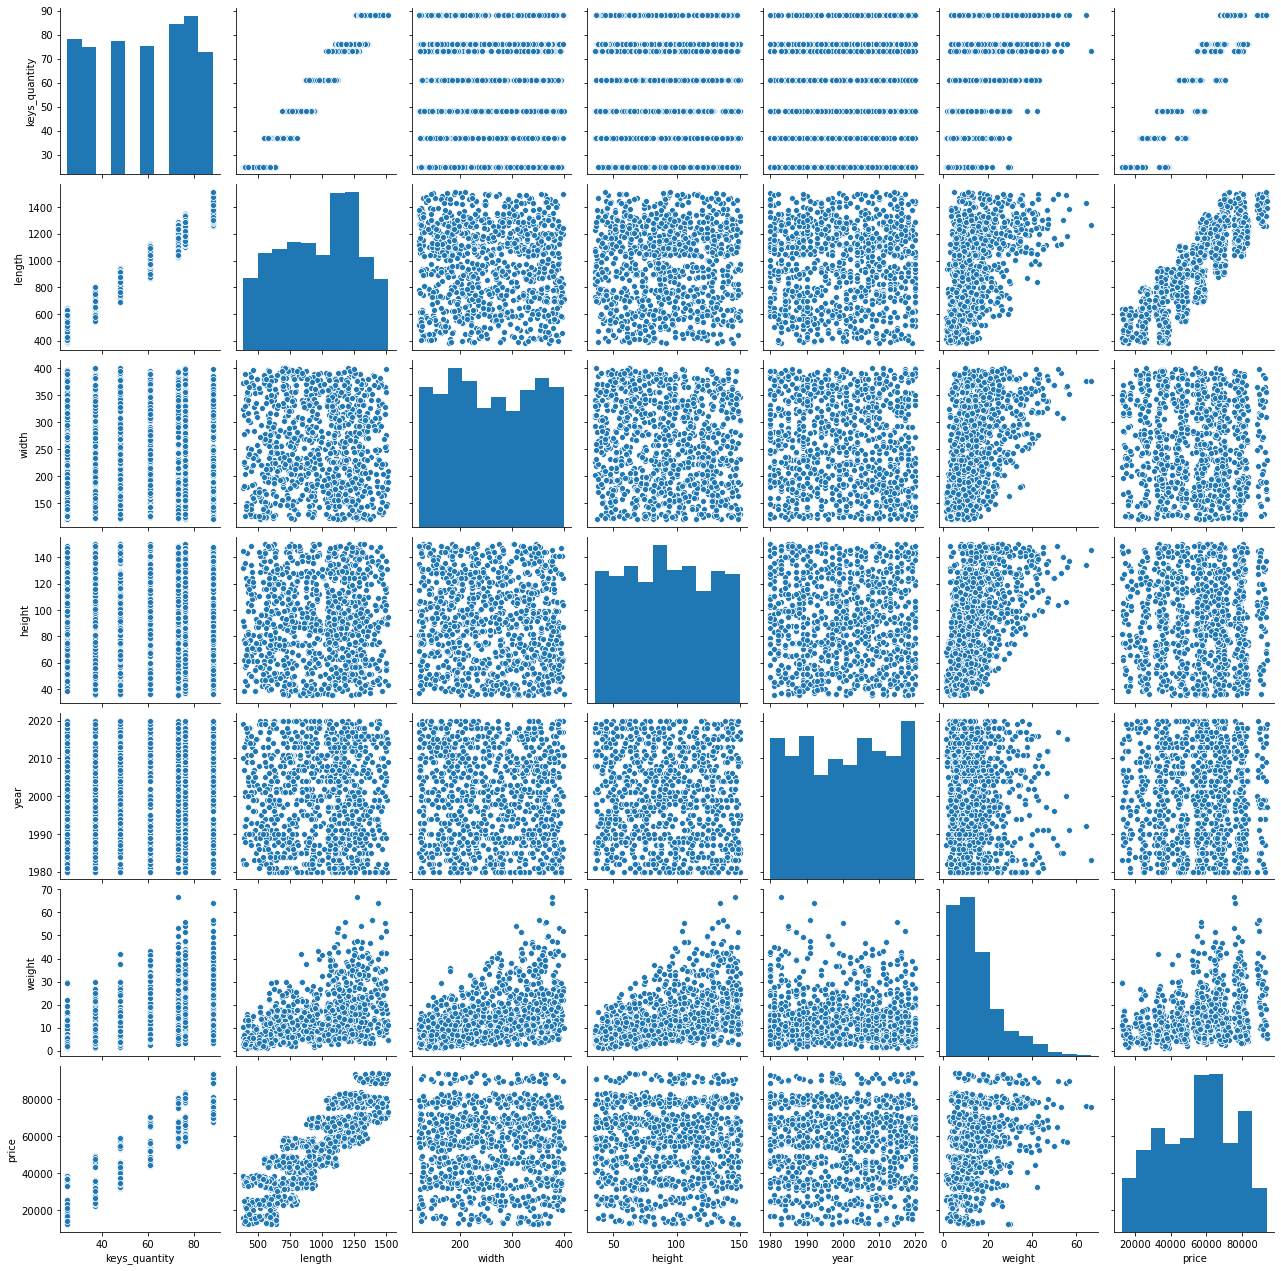

In [314]:
# и основные завиимости
sns.pairplot(df)

Если смотреть на цену, то бросается в глаза её сегментация в зависимости в первую очередь от количества клавиш и от длины. 

Будем порверять различные гипотезы. Для удобства добавлю функцию, в которой будет обучаться линейная модель и выводиться информация о коэффициентах и ошибке. Т.к. предполагается простая линейная регрессия в качестве метрики ошибки беру MSE 

In [270]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [301]:
def score_and_coef(X, Y):
    reg = LinearRegression().fit(X, Y)
    print('Coefficients:')
    for k, col in list(zip(reg.coef_[0], X.columns)):
        print(f'Weight {k} ({col})')
    print(f'Bias: {reg.intercept_}')

    pred_values = reg.predict(X)
    print(f'Error: {mean_squared_error(pred_values, Y)}')
    

Для начала опробуем линейную регрессию на всех числовых столбцах

In [302]:
columns = ['keys_quantity', 'length', 'width', 'height', 'year', 'weight']
X = df[columns]
Y = df[['price']] 
score_and_coef(X, Y)

Coefficients:
Weight 861.9918568540526 (keys_quantity)
Weight 3.976909921033748 (length)
Weight 10.54048762417401 (width)
Weight 21.08432195395242 (height)
Weight -12.151109548530947 (year)
Weight -145.69080248066436 (weight)
Bias: [21925.01901985]
Error: 77149256.43053366


Ошибка большая. Двигаемся дальше. Попробуем убрать год выпуска. Он, как уже говорилось, вряд ли даст много информации о цене. 

In [303]:
columns = ['keys_quantity', 'length', 'width', 'height', 'weight']
X = df[columns]
Y = df[['price']] 
score_and_coef(X, Y)

Coefficients:
Weight 860.7461416070356 (keys_quantity)
Weight 4.0380474693757495 (length)
Weight 10.648193253413957 (width)
Weight 21.317572389916204 (height)
Weight -145.49783194797288 (weight)
Bias: [-2413.45906483]
Error: 77170380.78247301


Ситуация изменилась незначительно, двигаемся дальше

Модель может много сказать о цене, т.к. представленные здесь - ярко выраженные представители разных ценовых сегментов. Сделаем one hot encoding и посмотрим, как это повлияет на регрессию

In [304]:
dummies = pd.get_dummies(df['model'])
df = pd.concat([df.drop(['model'], axis=1), dummies], axis=1)
df.head(10)

,keys_quantity,length,width,height,year,weight,price,Casio,Korg,Nord
0,37,719,353,44,1981,8.867001,45211.0,0,0,1
1,73,1195,183,126,1981,17.800084,65149.0,0,1,0
2,76,1173,188,143,2004,10.154248,62543.0,1,0,0
3,37,673,391,71,2002,17.954510,30791.5,0,1,0
4,76,1108,234,129,1993,27.927483,79182.5,0,0,1
5,73,1126,277,102,2011,15.429792,79517.5,0,0,1
6,37,718,158,69,2001,4.031233,47582.5,0,0,1
7,73,1288,138,122,2020,7.676408,59631.0,1,0,0
8,61,894,373,137,2011,16.446346,49020.0,1,0,0
9,73,1102,177,68,1995,9.921227,56282.0,1,0,0


In [305]:
columns = ['keys_quantity', 'length', 'width', 'height', 'weight', 'Casio', 'Korg', 'Nord']
X = df[columns]
Y = df[['price']] 
score_and_coef(X, Y)

Coefficients:
Weight 875.5557062610163 (keys_quantity)
Weight 3.498005351365108 (length)
Weight 11.94934103196651 (width)
Weight 34.47091721809437 (height)
Weight -214.11617135307606 (weight)
Weight -9672.21153464977 (Casio)
Weight -1702.4695723786272 (Korg)
Weight 11374.68110702841 (Nord)
Bias: [-3597.02206904]
Error: 1280557.0457326712


По сравнению с предыдущим шагом ошибка уменьшилась существенно. Но модель можно еще улучшить.  

Логично что длина инструмента напрямую зависит от количества клавиш, значит одна переменная несет много информации о другой. Соответственно использовать в модели и ту, и другую будет излишне. Так же очевидно, что чем больше габариты, тем больше и вес инструмента. Попробуем оставить базовую характеристику "Количество клавиш", а размеры и вес убрать.  

In [306]:
columns = ['keys_quantity', 'Casio', 'Korg', 'Nord']
X = df[columns]
Y = df[['price']] 
score_and_coef(X, Y)

Coefficients:
Weight 877.6249015219818 (keys_quantity)
Weight -9545.028930248624 (Casio)
Weight -1773.6803866460823 (Korg)
Weight 11318.709316894698 (Nord)
Bias: [2745.75540415]
Error: 3016582.1654022206


Ошибка выросла. Попробуем вернуть в модель вес, он в меньшей степени зависит от количества клавиш, чем длина.

In [307]:
columns = ['keys_quantity','weight', 'Casio', 'Korg', 'Nord']
X = df[columns]
Y = df[['price']] 
score_and_coef(X, Y)

Coefficients:
Weight 899.1202372900163 (keys_quantity)
Weight -96.62137457010131 (weight)
Weight -9629.06333251251 (Casio)
Weight -1718.721677784896 (Korg)
Weight 11347.785010297275 (Nord)
Bias: [2921.66246568]
Error: 2167889.7246350045


Это было шагом в правильном направлении, вес некоторым образом влияет на модель, ошибка уменьшилась. Но, скажу со своей точки зрения, больше должен влиять не сам вес, а вес в соотношении с габаритами. 88-клавишная 1.5-метровая клавиатура может весить 10 кг, но это очень малый вес при её размерах. И хотелось бы, как и со многими современными гаджетами, чтобы удельный вес инструмента был меньше. Поэтому введем новый столбец, который из имеющихся габаритов (в мм) и веса (в кг) рассчитает удельный вес ("плотность" в кг/м3), и введем его в модель.

In [308]:
df.loc[:, 'density'] = data_copy.apply(lambda x: (x['weight']*10**9)/(x['length']*x['width']*x['height']), axis=1)
df.head()

,keys_quantity,length,width,height,year,weight,price,Casio,Korg,Nord,density
0,37,719,353,44,1981,8.867001,45211.0,0,0,1,794.0
1,73,1195,183,126,1981,17.800084,65149.0,0,1,0,646.0
2,76,1173,188,143,2004,10.154248,62543.0,1,0,0,322.0
3,37,673,391,71,2002,17.954510,30791.5,0,1,0,961.0
4,76,1108,234,129,1993,27.927483,79182.5,0,0,1,835.0


In [311]:
columns = ['keys_quantity','density', 'Casio', 'Korg', 'Nord']
X = df[columns]
Y = df[['price']] 
score_and_coef(X, Y)

Coefficients:
Weight 880.0000000000001 (keys_quantity)
Weight -8.499999999999979 (density)
Weight -9666.666666666633 (Casio)
Weight -1666.6666666666256 (Korg)
Weight 11333.33333333337 (Nord)
Bias: [8066.66666667]
Error: 2.7335672266917396e-22


Ошибка упала почти до 0, к чему мы и стремились. Так что остановимся на этом этапе.

### Формирование датасета

In [280]:
n_samples = 1000
keys_number = [25, 37, 48, 61, 73, 76, 88]
model_names = ['Casio', 'Korg', 'Nord']

keys_quantity = np.random.choice(keys_number, n_samples)
model = np.random.choice(model_names, n_samples)

data = pd.DataFrame({'keys_quantity': keys_quantity, 'model': model})
data.head(5)

,keys_quantity,model
0,37,Nord
1,73,Korg
2,76,Casio
3,37,Korg
4,76,Nord


Длину рассчитаем от количества клавиш. Ширина одной белой с учетом зазора между соседними в среднем примерно 23 мм, умножим ее на количество белых клавиш плюс добавим некоторое рандомное количество мм на продолжение корпуса по бокам 

In [281]:
def find_keyboard_len(keys_number):
    white_keys = (keys_number//12)*7 + keys_number%12
    return white_keys*23 + np.random.randint(40, 301)
    

In [282]:
data.loc[:, 'length'] = data['keys_quantity'].apply(find_keyboard_len)
data.head(15)

,keys_quantity,model,length
0,37,Nord,719
1,73,Korg,1195
2,76,Casio,1173
3,37,Korg,673
4,76,Nord,1108
5,73,Nord,1126
6,37,Nord,718
7,73,Casio,1288
8,61,Casio,894
9,73,Casio,1102


Ширина и высота в больше степени зависят от конструкции, чем от количества клавиш. Можно найти инстументы с 88 клавишами более узкие и плоские, чем с 25 клавишами. Поэтому просто зададим рандомные значения этих параметров, которые будут варьироваться в некоторых разумных пределах. 

In [283]:
width = lambda x: np.random.randint(120, 401)
height = lambda x: np.random.randint(35, 151)

In [284]:
data.loc[:, 'width'] = data.apply(width, axis=1)
data.loc[:, 'height'] = data.apply(height, axis=1)
data.head(15)

,keys_quantity,model,length,width,height
0,37,Nord,719,353,44
1,73,Korg,1195,183,126
2,76,Casio,1173,188,143
3,37,Korg,673,391,71
4,76,Nord,1108,234,129
5,73,Nord,1126,277,102
6,37,Nord,718,158,69
7,73,Casio,1288,138,122
8,61,Casio,894,373,137
9,73,Casio,1102,177,68


Год выпуска будем брать произвольно от 1980 до 2020

In [285]:
data.loc[:, 'year'] = data.apply(lambda x: np.random.randint(1980, 2021), axis=1)
data.head(15)

,keys_quantity,model,length,width,height,year
0,37,Nord,719,353,44,1981
1,73,Korg,1195,183,126,1981
2,76,Casio,1173,188,143,2004
3,37,Korg,673,391,71,2002
4,76,Nord,1108,234,129,1993
5,73,Nord,1126,277,102,2011
6,37,Nord,718,158,69,2001
7,73,Casio,1288,138,122,2020
8,61,Casio,894,373,137,2011
9,73,Casio,1102,177,68,1995


Наконец вес зависит и от габаритов и от конструкции (металл или пластик в корпусе, наличие/отсутствие внутренних динамиков и пр.). Поэтому будем рассчитывать его как объем умноженный на некоторую условную "плотность" синтезатора, которую тоже выберем произвольно, а к этому произведению прибавлять или вычитать некоторое рандомное число, не превышающее само произведение, для большей "зашумленности"  

In [286]:
def find_keyboard_weight(row):
    volume = row['length']*row['width']*row['height']/(10**9) #переводим из мм3 в м3
    tmp_weight = volume*np.random.randint(300,1001)
    weight = tmp_weight + np.random.uniform((tmp_weight/2)*(-1), tmp_weight/2) #прибавляем или вычитаем в пределах трети веса
    return tmp_weight
    

In [287]:
data.loc[:, 'weight'] = data.apply(find_keyboard_weight, axis=1)
data.head(15)

,keys_quantity,model,length,width,height,year,weight
0,37,Nord,719,353,44,1981,8.867001
1,73,Korg,1195,183,126,1981,17.800084
2,76,Casio,1173,188,143,2004,10.154248
3,37,Korg,673,391,71,2002,17.954510
4,76,Nord,1108,234,129,1993,27.927483
5,73,Nord,1126,277,102,2011,15.429792
6,37,Nord,718,158,69,2001,4.031233
7,73,Casio,1288,138,122,2020,7.676408
8,61,Casio,894,373,137,2011,16.446346
9,73,Casio,1102,177,68,1995,9.921227


In [288]:
data.describe()

,keys_quantity,length,width,height,year,weight
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,58.706000,970.578000,258.742000,91.795000,1999.827000,14.894169
std,20.802411,300.729194,82.318028,32.939399,12.033365,10.630418
min,25.000000,385.000000,120.000000,35.000000,1980.000000,1.157515
25%,37.000000,720.750000,187.000000,64.000000,1989.000000,7.154733
50%,61.000000,1029.000000,257.000000,92.000000,2000.000000,12.042372
75%,76.000000,1216.000000,334.000000,120.000000,2010.000000,19.434522
max,88.000000,1515.000000,400.000000,150.000000,2020.000000,66.754195


Большой вес в районе 60 кг на практике - редкость, но в остальном выглядит правдоподобно.

In [289]:
data_copy = data.copy()

In [290]:
dummies = pd.get_dummies(data_copy['model'])
data_copy = pd.concat([data_copy.drop(['model'], axis=1), dummies], axis=1)
data_copy.head(10)

,keys_quantity,length,width,height,year,weight,Casio,Korg,Nord
0,37,719,353,44,1981,8.867001,0,0,1
1,73,1195,183,126,1981,17.800084,0,1,0
2,76,1173,188,143,2004,10.154248,1,0,0
3,37,673,391,71,2002,17.954510,0,1,0
4,76,1108,234,129,1993,27.927483,0,0,1
5,73,1126,277,102,2011,15.429792,0,0,1
6,37,718,158,69,2001,4.031233,0,0,1
7,73,1288,138,122,2020,7.676408,1,0,0
8,61,894,373,137,2011,16.446346,1,0,0
9,73,1102,177,68,1995,9.921227,1,0,0


Вернемся к использованной при расчете веса "плотности" синтезатора (кг/м3). Я хочу ввести её в модель как один из факторов, который формирует цену. В реальной жизни при покупке обычно обращаешь внимание на соотношение габритов и веса инструмента. Если предполагается, что инструмент будет активно использоваться, то он будет и активно транспортироваться (как минимум от репетиционной точки до места выступления и обратно), а в этом случае при прочих равных ориентируешься на модель полегче. Поэтому здесь я хочу, чтобы удельный вес инструмента снижал цену: если производитель сделал тяжелый для своих размеров синтезатор, то он делает его более дешевым, чтоб его хоть кто-то покупал.  

In [291]:
data_copy.loc[:, 'density'] = data_copy.apply(lambda x: (x['weight']*10**9)/(x['length']*x['width']*x['height']), axis=1)
data_copy.head()

,keys_quantity,length,width,height,year,weight,Casio,Korg,Nord,density
0,37,719,353,44,1981,8.867001,0,0,1,794.0
1,73,1195,183,126,1981,17.800084,0,1,0,646.0
2,76,1173,188,143,2004,10.154248,1,0,0,322.0
3,37,673,391,71,2002,17.954510,0,1,0,961.0
4,76,1108,234,129,1993,27.927483,0,0,1,835.0


In [292]:
data_copy.sort_values(by=['density'])

,keys_quantity,length,width,height,year,weight,Casio,Korg,Nord,density
894,25,431,364,116,1990,5.459563,1,0,0,300.0
536,76,1296,303,150,1985,17.670960,1,0,0,300.0
784,76,1320,332,108,1991,14.198976,0,1,0,300.0
843,76,1201,185,114,2016,7.624056,0,1,0,301.0
971,88,1445,248,76,1991,8.279549,1,0,0,304.0
...,...,...,...,...,...,...,...,...,...,...
647,37,627,329,129,2007,26.557286,1,0,0,998.0
102,48,828,189,145,2010,22.645957,0,1,0,998.0
97,76,1191,150,78,2005,13.920765,1,0,0,999.0
164,73,1059,261,145,1990,40.077855,0,1,0,1000.0


В итоге цена будет формироваться по следующим правилам: 
* количество клавиш - увеличивает цену
* Casio - дешевая модель, уменьшает цену
* Korg - умеренно увеличивает цену
* Nord - сильно увеличивает цену
* удельный вес - уменьшает цену
* плюс некое смещение

In [293]:
def get_price(x):
    return 880*x['keys_quantity'] - 6000*x['Casio'] + 2000*x['Korg'] + 15000*x['Nord'] - 8.5*x['density'] + 4400

In [294]:
data_copy.loc[:, 'price'] = data_copy.apply(get_price, axis=1)
data_copy.head()

,keys_quantity,length,width,height,year,weight,Casio,Korg,Nord,density,price
0,37,719,353,44,1981,8.867001,0,0,1,794.0,45211.0
1,73,1195,183,126,1981,17.800084,0,1,0,646.0,65149.0
2,76,1173,188,143,2004,10.154248,1,0,0,322.0,62543.0
3,37,673,391,71,2002,17.954510,0,1,0,961.0,30791.5
4,76,1108,234,129,1993,27.927483,0,0,1,835.0,79182.5


In [295]:
data_copy.sort_values(by=['price'])

,keys_quantity,length,width,height,year,weight,Casio,Korg,Nord,density,price
944,25,423,340,82,1997,11.215371,1,0,0,951.0,12316.5
16,25,404,216,124,2014,10.139030,1,0,0,937.0,12435.5
638,25,602,350,149,2010,29.385065,1,0,0,936.0,12444.0
22,25,641,353,145,1983,29.955151,1,0,0,913.0,12639.5
426,25,466,369,99,2006,15.150867,1,0,0,890.0,12835.0
...,...,...,...,...,...,...,...,...,...,...,...
192,88,1471,173,69,2016,6.935934,0,0,1,395.0,93482.5
852,88,1499,355,137,2004,27.120238,0,0,1,372.0,93678.0
257,88,1259,176,67,2018,5.433683,0,0,1,366.0,93729.0
716,88,1444,230,62,2019,7.145230,0,0,1,347.0,93890.5


In [296]:
data = pd.concat([data, data_copy['price']], axis=1)
data.head()

,keys_quantity,model,length,width,height,year,weight,price
0,37,Nord,719,353,44,1981,8.867001,45211.0
1,73,Korg,1195,183,126,1981,17.800084,65149.0
2,76,Casio,1173,188,143,2004,10.154248,62543.0
3,37,Korg,673,391,71,2002,17.954510,30791.5
4,76,Nord,1108,234,129,1993,27.927483,79182.5


In [297]:
data.to_csv('keabord_prices.csv')